# Project: Vehicle Detection
---
### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Import Packages


In [1]:
# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import cv2
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label


# Global debug flags
DEBUG = False

## Train A Classifier For Vehicle Detection


### Define helper functions for feature extraction and training of the classifier

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Extract hog features (Histogram of Oriented Gradients) from a given (single color) image.
    """
    if vis == True:
        # Call with two outputs if vis==True
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    """
    Extract color features from a given image.
    """
    # Extract features from each color channel individually
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Combine the three feature vectors and return the result
    return np.hstack((color1, color2, color3))
 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    A function to compute color histogram features.
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(image, cspace='YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
                     spatial_size=8,
                     hist_bins=32, hist_range=(0, 256),
                     hog_orient = 8, hog_pix_per_cell = 16, hog_cell_per_block = 2,
                     hog_channel = 'ALL'): # Can be 0, 1, 2, or "ALL"
    """
    Extract spacial color features, color histogram features and hog features from a given image.
    Return the extracted features as a single feature vector.
    """

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)  
    
    
    # Apply bin_spatial() to get spatial color features
    color_features = bin_spatial(feature_image, size=(spatial_size,spatial_size))

    # Apply color_hist() to get color histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                hog_orient, hog_pix_per_cell, hog_cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], hog_orient, 
                    hog_pix_per_cell, hog_cell_per_block, vis=False, feature_vec=True)
    
    # Concatenate hog features, histogram features and color features and return the result
    return np.concatenate((hog_features, hist_features, color_features))

### Import and explore dataset

No. of imported vehicle images: 8806
No. of imported non-vehicle images: 8973
Image shape: (64, 64, 3)
Image data type: uint8


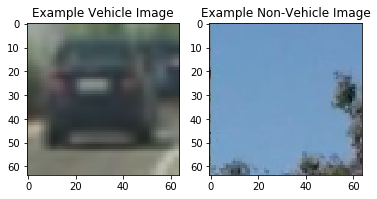

In [3]:
# Get file names
car_img_files = glob.glob('training_data/vehicles/*/*.png')
noncar_img_files = glob.glob('training_data/non-vehicles/*/*.png')

# Limit size of data sets for debugging
if DEBUG:
    car_img_files = car_img_files[:]
    noncar_img_files = noncar_img_files[:]
    #print(car_img_files)
    print(len(car_img_files))

# Explore dataset
print("No. of imported vehicle images: {:}".format(len(car_img_files)))
print("No. of imported non-vehicle images: {:}".format(len(noncar_img_files)))
# Read example images
car_img = cv2.imread(car_img_files[0])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
noncar_img = cv2.imread(noncar_img_files[0])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_BGR2RGB)
print("Image shape: {:}".format(car_img.shape))
print("Image data type: {:}".format(car_img.dtype))

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_img)
plt.title('Example Vehicle Image')
plt.subplot(122)
plt.imshow(noncar_img)
plt.title('Example Non-Vehicle Image')
plt.show()

### Feature extraction and classifier training

In [4]:
### Feature extraction ###
car_features = []
for car_img_file in car_img_files:
    image = cv2.imread(car_img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    car_features.append(extract_features(image))
notcar_features = []
for noncar_img_file in noncar_img_files:
    image = cv2.imread(noncar_img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    notcar_features.append(extract_features(image))

### Normalize training data ###
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
if DEBUG: print("len(X) = {:}".format(len(X)))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
if DEBUG: print("len(scaled_X) = {:}".format(len(scaled_X)))

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
if DEBUG: print("len(y) = {:}".format(len(y)))

### Split up data into randomized training and test sets ###
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)
if DEBUG: print("len(X_train) = {:}".format(len(X_train)))
if DEBUG: print("len(y_test) = {:}".format(len(y_test)))


### Define and tain a classifier ###
# Use a linear SVC
clf = LinearSVC()
# Check the training time for the SVC
t = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))


### Calculate and output validation accuracy ###
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My predicts:         ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'no. labels')

if DEBUG:
    print(len(car_features))
    print(len(car_features[0]))

C:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9933
My predicts:          [ 1.  1.  0.  1.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  0.  1.  1.  1.]
0.002 Seconds to predict 10 no. labels


## Helper functions for vehicle detection pipeline


In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    x_step = int(xy_window[0] - xy_overlap[0] * xy_window[0])
    y_step = int(xy_window[1] - xy_overlap[1] * xy_window[1])
    # Compute the number of windows in x/y
    x_n_windows = int((x_span - xy_window[0]) / x_step + 1)
    y_n_windows = int((y_span - xy_window[1]) / y_step + 1)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for y in range(y_n_windows):
        for x in range(x_n_windows):
            # Calculate each window position
            x_start = x * x_step + x_start_stop[0]
            x_stop = x_start + xy_window[0]
            y_start = y * y_step + y_start_stop[0]
            y_stop = y_start + xy_window[1]
            # Append window position to list
            window_list.append(((x_start, y_start), (x_stop, y_stop)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draw boxes on a given image.
    
    Args:
        img: image to draw on
        bboxes (list): list of boxes to draw
        color ((int, int, int)): RGB color tuple
        thick (int): line thickness
    Returns:
        image including boxes
    """
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for (x1, y1), (x2, y2) in bboxes:
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
    # return the image copy with boxes drawn
    return draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bboxes.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    # Return bounding boxes
    return bboxes

## Class HeatmapBuffer


In [6]:
class HeatmapBuffer():
    """
    A class to hold a buffer of heatmaps.
    """
    def __init__(self, hist_size=4):
        # number of recent heatmaps that will be stored
        self.hist_size = hist_size
        
        # the heatmaps of the last n frames
        self.recent_heatmaps = []
        
        # best averaged heatmap
        self.heatmap_sum = None
        
    def update_history(self, heatmap):
        """
        Updates the history of this HeatmapBuffer object
        """
        # Remove oldest element(s), when list size is equal or bigger than hist_size
        if len(self.recent_heatmaps) >= self.hist_size:
            self.recent_heatmaps = self.recent_heatmaps[-(self.hist_size-1):]
        # Append newest heatmap
        self.recent_heatmaps.append(heatmap)
        # Add up all heatmaps in the list of recent_heatmaps
        self.heatmap_sum = np.sum(self.recent_heatmaps, axis=0)
    

## Vehicle Detection Pipeline


In [7]:
# Parameters...
# Overlap of search windows in x- and y-direction
xy_overlap = (0.6666, 0.6666)

def pipeline(image):
    """
    Vehicle detection pipeline.
    The pipeline receives an image and returns that image with rectangles on it that mark detected vehicles.
    """
    # Make a copy of the input image, so we don't change the original
    draw_image = image.copy()
    
    # Copy the HeatmapBuffer object which must have been defined outside of this function
    hb = my_heatmap_buffer
    
    windows = []
    # Create search windows of different sizes
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 520],
                    xy_window=(80, 80), xy_overlap=xy_overlap)
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 656],
                    xy_window=(128, 128), xy_overlap=xy_overlap)
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 680],
                    xy_window=(200, 200), xy_overlap=xy_overlap)
    
    if DEBUG: print("no. of search windows: {:}".format(len(windows)))
    
    # Search all windows for cars
    hot_windows = search_windows(image, windows, clf, X_scaler)                       
    
    # For debugging only:
    #return draw_boxes(draw_image, windows, color=(0, 0, 255), thick=5)
    #return draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=5)
    
    # Define threshold for each individual image / heatmap
    individual_thresh = 1
    # Define overall threshold for all images / heatmaps in the buffer
    overall_thresh = len(hb.recent_heatmaps) + 1
    
    # Initialize heatmap with zeros
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # Calculate heatmap for current image
    heatmap = add_heat(heatmap, hot_windows)
    # Apply threshold on current heatmap
    heatmap = apply_threshold(heatmap, individual_thresh)
    # Append current heatmap to buffer ("history")
    hb.update_history(heatmap)
    # Apply overall threshold on sum af all heatmaps in the buffer
    heatmap_sum = apply_threshold(hb.heatmap_sum, overall_thresh)
    # Extract indivudual detections
    labels = label(heatmap_sum)
    
    if DEBUG: print(labels[1], 'cars found')
    
    # Get bouding boxes for all individual detections ("labels")
    bboxes = get_labeled_bboxes(draw_image, labels)
    
    # Dismiss detections that are smaller than min_box_size...
    good_bboxes = []
    min_box_size = 50
    for bbox in bboxes:
        if DEBUG: print(bbox)
        if bbox[1][0] - bbox[0][0] >= min_box_size:
            if bbox[1][1] - bbox[0][1] >= min_box_size:
                good_bboxes.append(bbox)
    
    # Return image with rectangles that mark detected vehicles
    return draw_boxes(draw_image, good_bboxes, color=(0, 0, 255), thick=5)

## Apply The Pipeline To Test Images


C:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


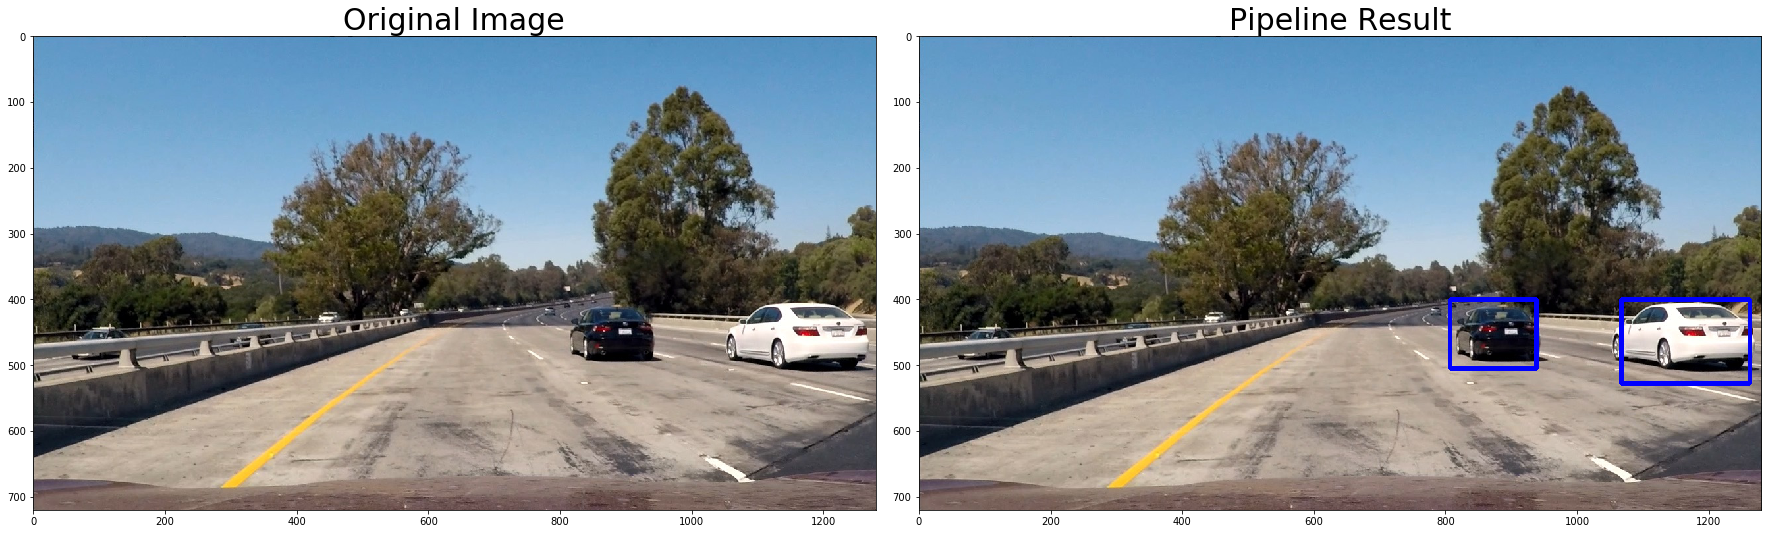

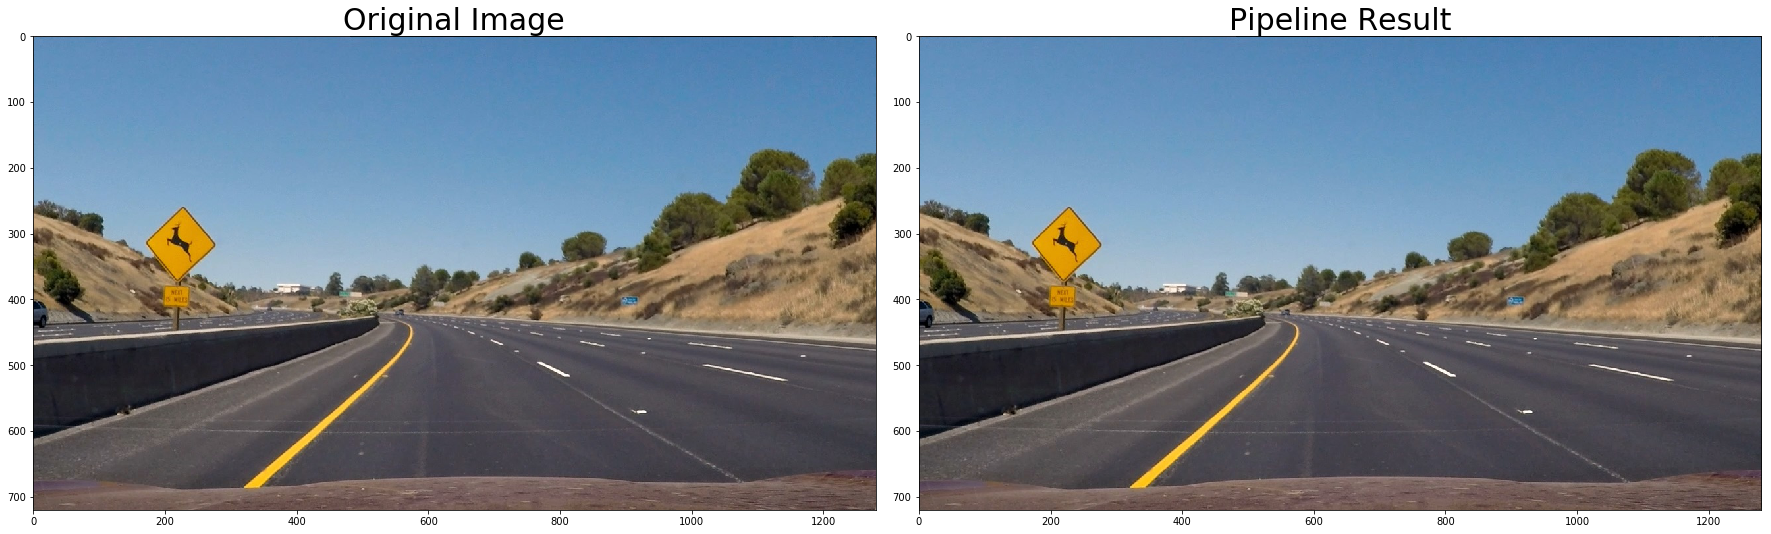

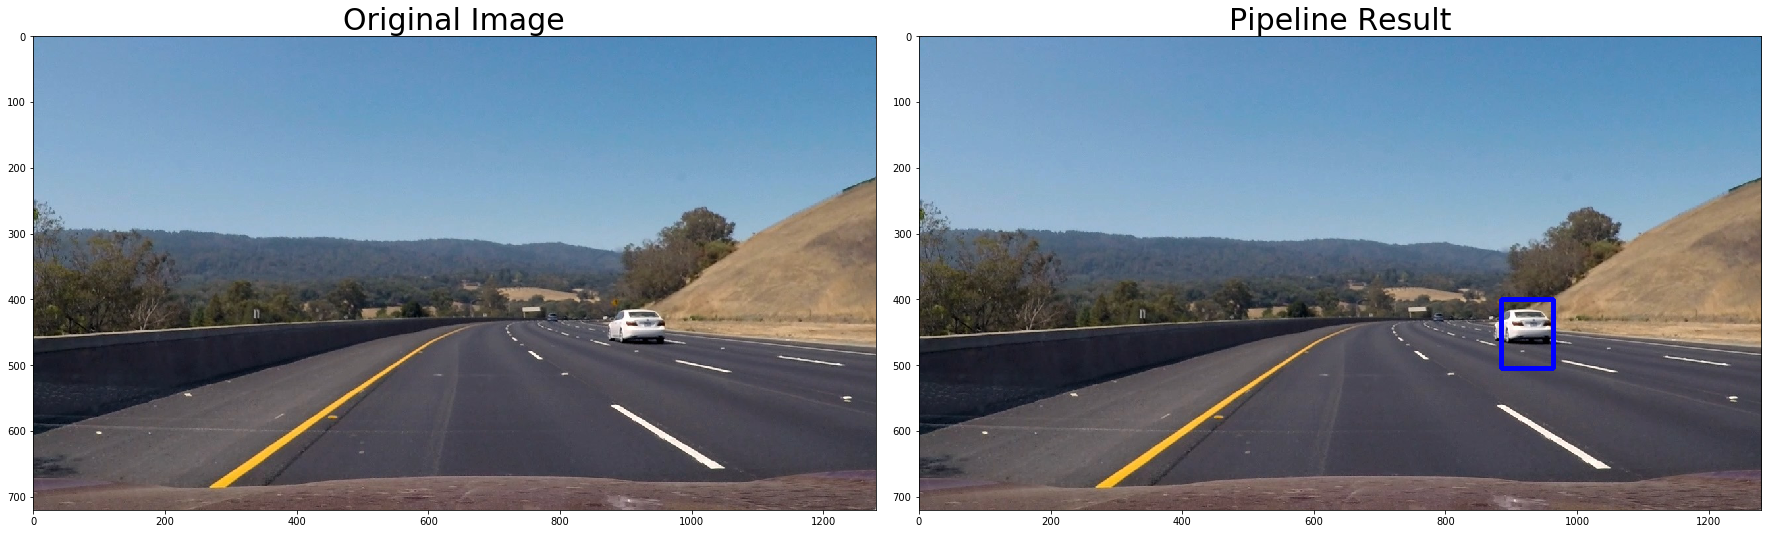

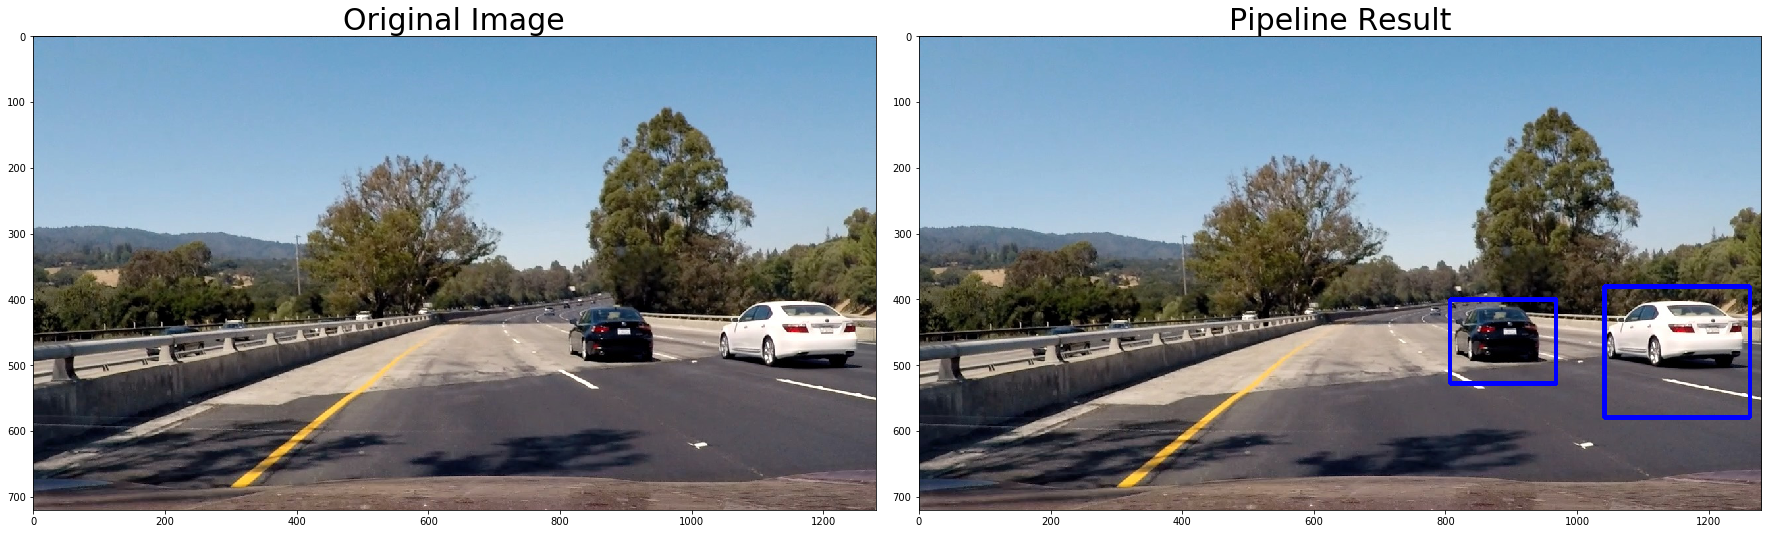

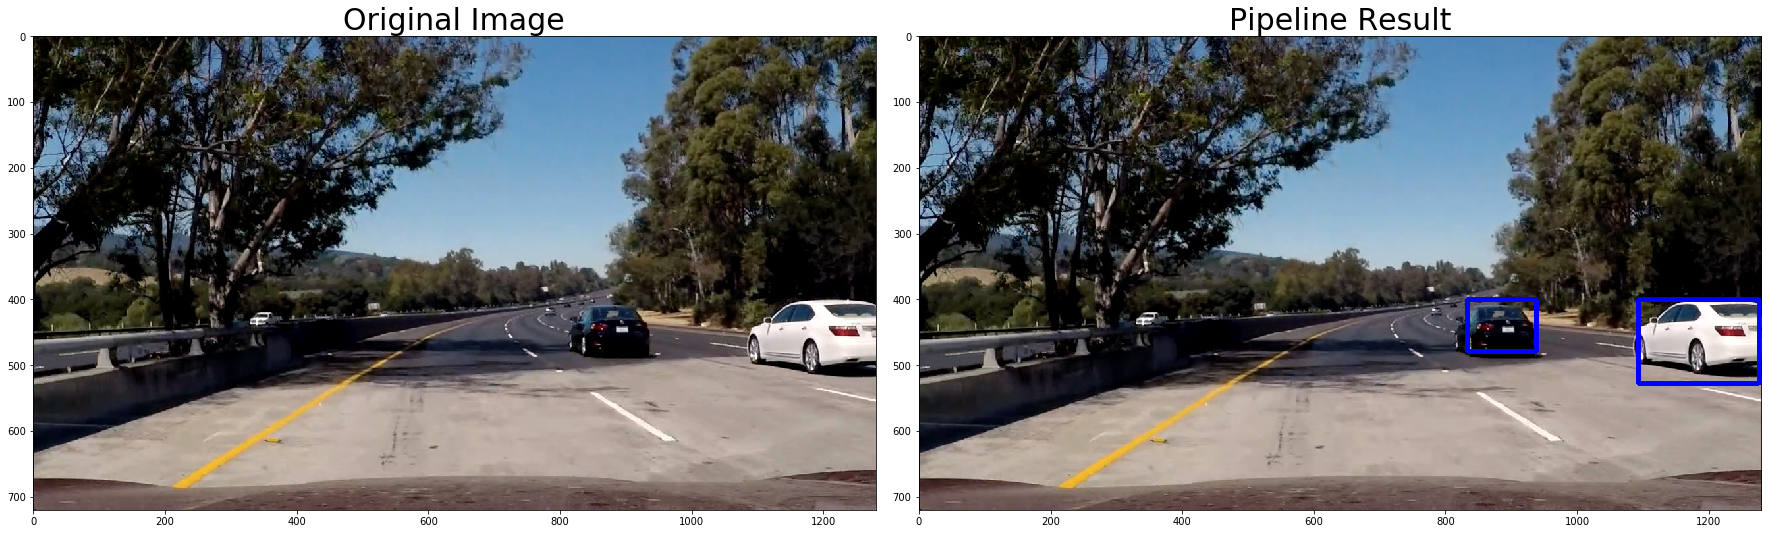

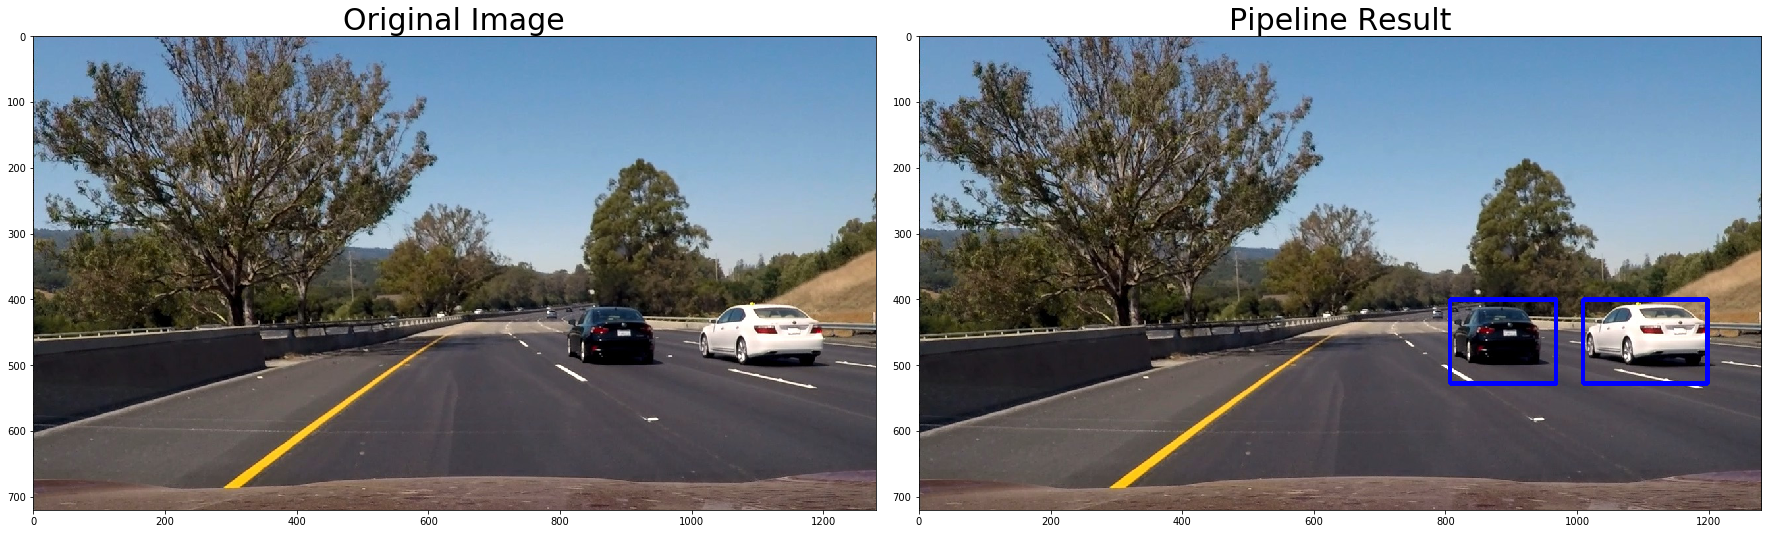

In [8]:
# Make a list of test images
fnames = glob.glob('test_images/*.jpg')

# Iterate trough all test images and apply the pipleline defined above

for filename in fnames:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get image shape
    img_size_y, img_size_x = img.shape[:2]
    
    
    # Create a HeatmapBuffer object
    my_heatmap_buffer = HeatmapBuffer(hist_size=1)
    
    #Run the lane detection pipeline
    result_img = pipeline(img)
    
    # Plot the resulting image next to the original image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(result_img)
    ax2.set_title('Pipeline Result', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.show()
    
    # Save image
    mpimg.imsave("output_images/" + filename.split('\\')[-1], result_img)
    
    time.sleep(0.01)

## Apply The Pipeline To Videos

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### test_video.mp4

In [10]:
output_file1 = 'output_videos/test_video.mp4'

clip1 = VideoFileClip("test_video.mp4")

# Get clip shape
img_size_x, img_size_y = clip1.size

# Create a HeatmapBuffer object
my_heatmap_buffer = HeatmapBuffer(hist_size=5)

clip1 = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1.write_videofile(output_file1, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:38<00:00,  1.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

Wall time: 39.5 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file1))

### project_video.mp4

In [12]:
output_file1 = 'output_videos/project_video.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(46,49.95) #use a subclip for debugging .subclip(start_second,end_second)
clip1 = VideoFileClip("project_video.mp4")

# Get clip shape
img_size_x, img_size_y = clip1.size

# Create a HeatmapBuffer object
my_heatmap_buffer = HeatmapBuffer(hist_size=5)

clip1 = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1.write_videofile(output_file1, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [18:11<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 18min 12s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file1))